C:\Users\Proly Kumar\AppData\Local\anaconda3\envs\tensorflow-gpu-01\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


🔬 ABLATION STUDY FOR HiC-SuperNet

📂 Loading datasets...
✓ Train: 625 batches
✓ Valid: 125 batches
✓ Test: 697 batches

🧪 Experiment 1/12: Full Model
   Multi-Scale: True
   Attention: True
   Filters: 64
   Blocks: 8
   Loss: Full Loss

✓ Parameters: 791,445

🚀 Training...
Epoch 1/50
625/625 - 273s - loss: 0.1604 - mae: 0.0200 - val_loss: 0.1486 - val_mae: 0.0142 - 273s/epoch - 437ms/step
Epoch 2/50
625/625 - 30s - loss: 0.1404 - mae: 0.0141 - val_loss: 0.1365 - val_mae: 0.0117 - 30s/epoch - 48ms/step
Epoch 3/50
625/625 - 30s - loss: 0.1373 - mae: 0.0131 - val_loss: 0.1360 - val_mae: 0.0152 - 30s/epoch - 48ms/step
Epoch 4/50
625/625 - 30s - loss: 0.1357 - mae: 0.0126 - val_loss: 0.1341 - val_mae: 0.0112 - 30s/epoch - 48ms/step
Epoch 5/50
625/625 - 30s - loss: 0.1346 - mae: 0.0121 - val_loss: 0.1320 - val_mae: 0.0108 - 30s/epoch - 48ms/step
Epoch 6/50
625/625 - 30s - loss: 0.1337 - mae: 0.0118 - val_loss: 0.1325 - val_mae: 0.0118 - 30s/epoch - 48ms/step
Epoch 7/50
625/625 - 30s - loss:

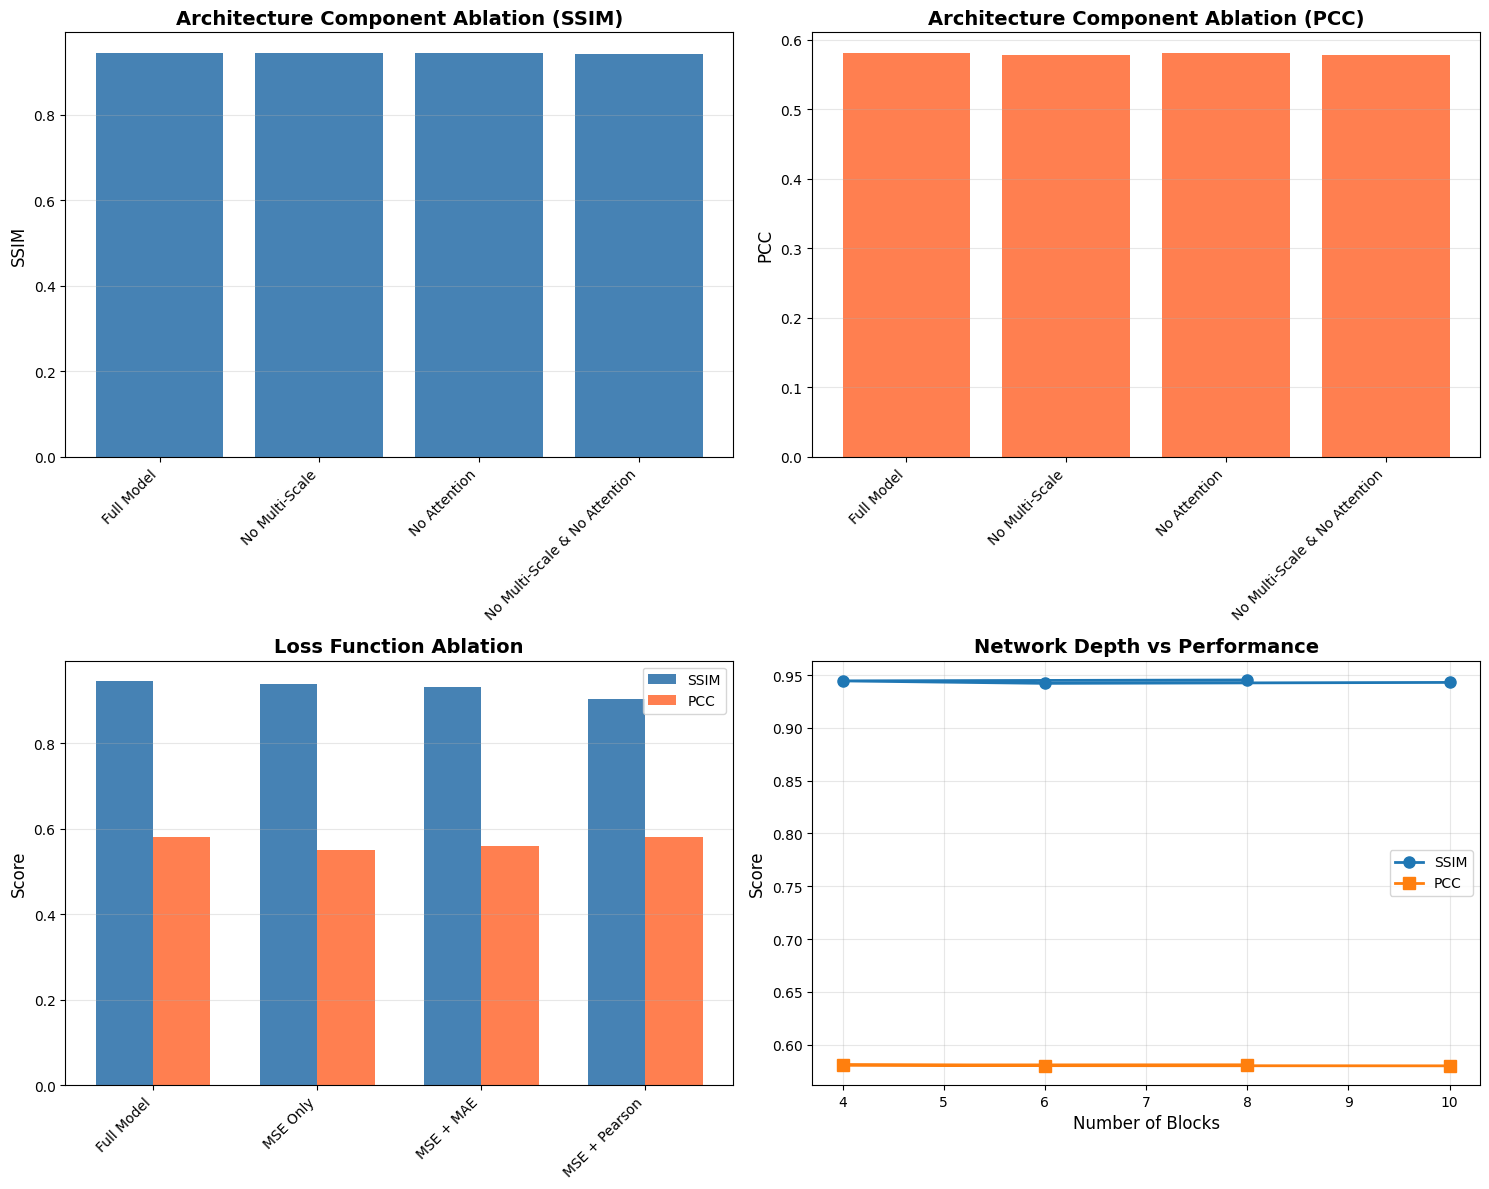


✅ Ablation study complete!


In [1]:
"""
Ablation Study for HiC-SuperNet
================================

Tests the contribution of each component:
1. Multi-scale dilation (d=1,2,4 vs d=1 only)
2. Dual attention (with vs without)
3. Loss components (different combinations)
4. Number of blocks (4, 6, 8, 10)
5. Base filters (32, 48, 64)

Compares all variants on GM12878 test set
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import pandas as pd
import matplotlib.pyplot as plt

# ==================== GPU Configuration ====================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"⚠ GPU warning: {e}")

# ==================== Component Variants ====================

# ==================== Standard Multi-Scale Dilated ResBlock ====================
class MultiScaleDilatedResBlock(layers.Layer):
    """Full version with d=1,2,4"""
    def __init__(self, filters, **kwargs):
        super(MultiScaleDilatedResBlock, self).__init__(**kwargs)
        self.filters = filters
        
        self.conv_d1 = layers.Conv2D(filters // 3, 3, padding='same', dilation_rate=1)
        self.conv_d2 = layers.Conv2D(filters // 3, 3, padding='same', dilation_rate=2)
        self.conv_d4 = layers.Conv2D(filters // 3, 3, padding='same', dilation_rate=4)
        
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()
        
        self.conv2 = layers.Conv2D(filters, 3, padding='same')
        self.bn2 = layers.BatchNormalization()
        
        self.shortcut_conv = layers.Conv2D(filters, 1, padding='same')
        
    def call(self, x, training=False):
        shortcut = self.shortcut_conv(x)
        
        d1 = self.conv_d1(x)
        d2 = self.conv_d2(x)
        d4 = self.conv_d4(x)
        
        out = layers.Concatenate()([d1, d2, d4])
        out = self.bn1(out, training=training)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out, training=training)
        
        out = layers.Add()([out, shortcut])
        out = layers.ReLU()(out)
        
        return out
    
    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters})
        return config

# ==================== Single-Scale ResBlock (Ablation) ====================
class SingleScaleResBlock(layers.Layer):
    """Ablation: Only d=1 (no multi-scale)"""
    def __init__(self, filters, **kwargs):
        super(SingleScaleResBlock, self).__init__(**kwargs)
        self.filters = filters
        
        self.conv1 = layers.Conv2D(filters, 3, padding='same', dilation_rate=1)
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()
        
        self.conv2 = layers.Conv2D(filters, 3, padding='same')
        self.bn2 = layers.BatchNormalization()
        
        self.shortcut_conv = layers.Conv2D(filters, 1, padding='same')
        
    def call(self, x, training=False):
        shortcut = self.shortcut_conv(x)
        
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out, training=training)
        
        out = layers.Add()([out, shortcut])
        out = layers.ReLU()(out)
        
        return out
    
    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters})
        return config

# ==================== Dual Attention Module ====================
class DualAttention(layers.Layer):
    """Channel + Spatial Attention"""
    def __init__(self, filters, reduction=8, **kwargs):
        super(DualAttention, self).__init__(**kwargs)
        self.filters = filters
        self.reduction = reduction
        
        self.gap = layers.GlobalAveragePooling2D(keepdims=True)
        self.gmp = layers.GlobalMaxPooling2D(keepdims=True)
        self.fc1 = layers.Dense(filters // reduction, activation='relu')
        self.fc2 = layers.Dense(filters)
        
        self.spatial_conv = layers.Conv2D(1, 7, padding='same')
        
    def call(self, x):
        avg_pool = self.gap(x)
        max_pool = self.gmp(x)
        
        avg_pool = tf.reshape(avg_pool, [-1, self.filters])
        max_pool = tf.reshape(max_pool, [-1, self.filters])
        
        avg_out = self.fc2(self.fc1(avg_pool))
        max_out = self.fc2(self.fc1(max_pool))
        
        channel_att = tf.nn.sigmoid(avg_out + max_out)
        channel_att = tf.reshape(channel_att, [-1, 1, 1, self.filters])
        
        x = x * channel_att
        
        avg_out = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_out = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = layers.Concatenate()([avg_out, max_out])
        
        spatial_att = tf.nn.sigmoid(self.spatial_conv(concat))
        x = x * spatial_att
        
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'reduction': self.reduction
        })
        return config

# ==================== Model Builder with Ablation Options ====================
def build_ablation_model(input_size=(40, 40, 1),
                         base_filters=64,
                         num_blocks=8,
                         use_multi_scale=True,
                         use_attention=True,
                         model_name='HiC_Ablation'):
    """
    Build model with ablation options
    
    Args:
        use_multi_scale: If True, uses multi-scale dilation (d=1,2,4)
                        If False, uses single-scale (d=1 only)
        use_attention: If True, adds dual attention every 2 blocks
    """
    
    inputs = layers.Input(input_size, name='hic_input')
    
    # Initial feature extraction
    x = layers.Conv2D(base_filters, 7, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    initial_features = x
    
    # Stack of residual blocks
    for i in range(num_blocks):
        if use_multi_scale:
            x = MultiScaleDilatedResBlock(base_filters, name=f'res_block_{i}')(x)
        else:
            x = SingleScaleResBlock(base_filters, name=f'res_block_{i}')(x)
        
        # Add attention if enabled
        if use_attention and (i + 1) % 2 == 0:
            x = DualAttention(base_filters, name=f'dual_att_{i}')(x)
    
    # Global residual
    x = layers.Add()([x, initial_features])
    
    # Reconstruction
    x = layers.Conv2D(base_filters * 2, 3, padding='same', activation='relu',
                     kernel_initializer='he_normal')(x)
    x = layers.Conv2D(base_filters, 3, padding='same', activation='relu',
                     kernel_initializer='he_normal')(x)
    x = layers.Conv2D(base_filters // 2, 3, padding='same', activation='relu',
                     kernel_initializer='he_normal')(x)
    
    outputs = layers.Conv2D(1, 3, padding='same', activation='linear',
                          kernel_initializer='he_normal')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name=model_name)
    
    return model

# ==================== Loss Function Variants ====================
def mse_loss(y_true, y_pred):
    """Baseline: MSE only"""
    y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[1], tf.shape(y_true)[2], 1])
    y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[1], tf.shape(y_pred)[2], 1])
    return tf.reduce_mean(tf.square(y_true - y_pred))

def mse_mae_loss(y_true, y_pred):
    """MSE + MAE"""
    y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[1], tf.shape(y_true)[2], 1])
    y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[1], tf.shape(y_pred)[2], 1])
    
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    return 0.5 * mse + 0.5 * mae

def mse_pearson_loss(y_true, y_pred):
    """MSE + Pearson"""
    y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[1], tf.shape(y_true)[2], 1])
    y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[1], tf.shape(y_pred)[2], 1])
    
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    
    y_true_flat = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred_flat = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])
    
    y_true_mean = tf.reduce_mean(y_true_flat, axis=1, keepdims=True)
    y_pred_mean = tf.reduce_mean(y_pred_flat, axis=1, keepdims=True)
    
    y_true_centered = y_true_flat - y_true_mean
    y_pred_centered = y_pred_flat - y_pred_mean
    
    numerator = tf.reduce_sum(y_true_centered * y_pred_centered, axis=1)
    denominator = tf.sqrt(
        tf.reduce_sum(tf.square(y_true_centered), axis=1) * 
        tf.reduce_sum(tf.square(y_pred_centered), axis=1)
    )
    
    pearson = numerator / (denominator + 1e-8)
    pearson_loss = 1 - tf.reduce_mean(pearson)
    
    return 0.7 * mse + 0.3 * pearson_loss

def full_loss(y_true, y_pred):
    """Full loss: MSE + MAE + Pearson + SSIM"""
    y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[1], tf.shape(y_true)[2], 1])
    y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[1], tf.shape(y_pred)[2], 1])
    
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    y_true_flat = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred_flat = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])
    
    y_true_mean = tf.reduce_mean(y_true_flat, axis=1, keepdims=True)
    y_pred_mean = tf.reduce_mean(y_pred_flat, axis=1, keepdims=True)
    
    y_true_centered = y_true_flat - y_true_mean
    y_pred_centered = y_pred_flat - y_pred_mean
    
    numerator = tf.reduce_sum(y_true_centered * y_pred_centered, axis=1)
    denominator = tf.sqrt(
        tf.reduce_sum(tf.square(y_true_centered), axis=1) * 
        tf.reduce_sum(tf.square(y_pred_centered), axis=1)
    )
    
    pearson = numerator / (denominator + 1e-8)
    pearson_loss = 1 - tf.reduce_mean(pearson)
    
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    
    return 0.4 * mse + 0.2 * mae + 0.3 * pearson_loss + 0.1 * ssim_loss

# ==================== Data Generator ====================
class HiCDataGenerator(keras.utils.Sequence):
    def __init__(self, npz_file, batch_size=16, shuffle=True, max_samples=None):
        data = np.load(npz_file, allow_pickle=True)
        self.lr_data = data['data']
        self.hr_data = data['target']
        
        if max_samples:
            indices = np.random.choice(len(self.lr_data), max_samples, replace=False)
            self.lr_data = self.lr_data[indices]
            self.hr_data = self.hr_data[indices]
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.lr_data))
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.lr_data) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        lr_batch = np.array([self.lr_data[i] for i in batch_indexes])
        hr_batch = np.array([self.hr_data[i] for i in batch_indexes])
        
        if lr_batch.ndim == 4 and lr_batch.shape[1] == 1:
            lr_batch = lr_batch[:, 0, :, :]
        if hr_batch.ndim == 4 and hr_batch.shape[1] == 1:
            hr_batch = hr_batch[:, 0, :, :]
        
        if lr_batch.ndim == 3:
            lr_batch = np.expand_dims(lr_batch, axis=-1)
        if hr_batch.ndim == 3:
            hr_batch = np.expand_dims(hr_batch, axis=-1)
        
        return lr_batch.astype('float32'), hr_batch.astype('float32')
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# ==================== Metrics ====================
def calculate_ssim(img1, img2, C1=1e-4, C2=9e-4):
    img1 = img1.flatten()
    img2 = img2.flatten()
    
    mu1 = np.mean(img1)
    mu2 = np.mean(img2)
    sigma1 = np.std(img1)
    sigma2 = np.std(img2)
    sigma12 = np.mean((img1 - mu1) * (img2 - mu2))
    
    ssim = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / \
           ((mu1**2 + mu2**2 + C1) * (sigma1**2 + sigma2**2 + C2))
    
    return ssim

def calculate_psnr(img1, img2, max_val=None):
    mse = mean_squared_error(img1.flatten(), img2.flatten())
    if mse == 0:
        return float('inf')
    
    if max_val is None:
        max_val = max(np.max(img1), np.max(img2))
    
    psnr = 20 * math.log10(max_val / math.sqrt(mse))
    return psnr

def evaluate_model(model, test_gen, max_batches=50):
    """Evaluate model on test data"""
    all_metrics = []
    
    for i in range(min(max_batches, len(test_gen))):
        lr_batch, hr_batch = test_gen[i]
        pred_batch = model.predict(lr_batch, verbose=0)
        
        for j in range(len(lr_batch)):
            pred_flat = pred_batch[j, :, :, 0].flatten()
            target_flat = hr_batch[j, :, :, 0].flatten()
            
            mse = mean_squared_error(target_flat, pred_flat)
            mae = mean_absolute_error(target_flat, pred_flat)
            
            if np.std(pred_flat) > 0 and np.std(target_flat) > 0:
                pcc, _ = pearsonr(pred_flat, target_flat)
            else:
                pcc = np.nan
            
            ssim = calculate_ssim(pred_batch[j, :, :, 0], hr_batch[j, :, :, 0])
            psnr = calculate_psnr(pred_batch[j, :, :, 0], hr_batch[j, :, :, 0])
            
            all_metrics.append({
                'mse': mse,
                'mae': mae,
                'pcc': pcc,
                'ssim': ssim,
                'psnr': psnr
            })
    
    # Average
    avg_metrics = {}
    for key in all_metrics[0].keys():
        values = [m[key] for m in all_metrics if not np.isnan(m[key])]
        avg_metrics[key] = np.mean(values) if values else np.nan
    
    return avg_metrics

# ==================== Ablation Study Runner ====================
def run_ablation_study(train_npz, valid_npz, test_npz, 
                       epochs=50, batch_size=16, initial_lr=0.001):
    """
    Run complete ablation study
    """
    
    print("="*80)
    print("🔬 ABLATION STUDY FOR HiC-SuperNet")
    print("="*80)
    
    # Define ablation experiments
    experiments = [
        # Experiment 1: Architecture ablations
        {
            'name': 'Full Model',
            'use_multi_scale': True,
            'use_attention': True,
            'base_filters': 64,
            'num_blocks': 8,
            'loss_fn': full_loss,
            'loss_name': 'Full Loss'
        },
        {
            'name': 'No Multi-Scale',
            'use_multi_scale': False,
            'use_attention': True,
            'base_filters': 64,
            'num_blocks': 8,
            'loss_fn': full_loss,
            'loss_name': 'Full Loss'
        },
        {
            'name': 'No Attention',
            'use_multi_scale': True,
            'use_attention': False,
            'base_filters': 64,
            'num_blocks': 8,
            'loss_fn': full_loss,
            'loss_name': 'Full Loss'
        },
        {
            'name': 'No Multi-Scale & No Attention',
            'use_multi_scale': False,
            'use_attention': False,
            'base_filters': 64,
            'num_blocks': 8,
            'loss_fn': full_loss,
            'loss_name': 'Full Loss'
        },
        
        # Experiment 2: Loss function ablations
        {
            'name': 'MSE Only',
            'use_multi_scale': True,
            'use_attention': True,
            'base_filters': 64,
            'num_blocks': 8,
            'loss_fn': mse_loss,
            'loss_name': 'MSE'
        },
        {
            'name': 'MSE + MAE',
            'use_multi_scale': True,
            'use_attention': True,
            'base_filters': 64,
            'num_blocks': 8,
            'loss_fn': mse_mae_loss,
            'loss_name': 'MSE+MAE'
        },
        {
            'name': 'MSE + Pearson',
            'use_multi_scale': True,
            'use_attention': True,
            'base_filters': 64,
            'num_blocks': 8,
            'loss_fn': mse_pearson_loss,
            'loss_name': 'MSE+Pearson'
        },
        
        # Experiment 3: Network depth
        {
            'name': '4 Blocks',
            'use_multi_scale': True,
            'use_attention': True,
            'base_filters': 64,
            'num_blocks': 4,
            'loss_fn': full_loss,
            'loss_name': 'Full Loss'
        },
        {
            'name': '6 Blocks',
            'use_multi_scale': True,
            'use_attention': True,
            'base_filters': 64,
            'num_blocks': 6,
            'loss_fn': full_loss,
            'loss_name': 'Full Loss'
        },
        {
            'name': '10 Blocks',
            'use_multi_scale': True,
            'use_attention': True,
            'base_filters': 64,
            'num_blocks': 10,
            'loss_fn': full_loss,
            'loss_name': 'Full Loss'
        },
        
        # Experiment 4: Network width
        {
            'name': '32 Filters',
            'use_multi_scale': True,
            'use_attention': True,
            'base_filters': 32,
            'num_blocks': 8,
            'loss_fn': full_loss,
            'loss_name': 'Full Loss'
        },
        {
            'name': '48 Filters',
            'use_multi_scale': True,
            'use_attention': True,
            'base_filters': 48,
            'num_blocks': 8,
            'loss_fn': full_loss,
            'loss_name': 'Full Loss'
        },
    ]
    
    # Load data
    print("\n📂 Loading datasets...")
    train_gen = HiCDataGenerator(train_npz, batch_size=batch_size, max_samples=10000)
    valid_gen = HiCDataGenerator(valid_npz, batch_size=batch_size, max_samples=2000, shuffle=False)
    test_gen = HiCDataGenerator(test_npz, batch_size=batch_size, shuffle=False)
    
    print(f"✓ Train: {len(train_gen)} batches")
    print(f"✓ Valid: {len(valid_gen)} batches")
    print(f"✓ Test: {len(test_gen)} batches")
    
    results = []
    
    # Run each experiment
    for exp_idx, exp in enumerate(experiments):
        print("\n" + "="*80)
        print(f"🧪 Experiment {exp_idx+1}/{len(experiments)}: {exp['name']}")
        print(f"   Multi-Scale: {exp['use_multi_scale']}")
        print(f"   Attention: {exp['use_attention']}")
        print(f"   Filters: {exp['base_filters']}")
        print(f"   Blocks: {exp['num_blocks']}")
        print(f"   Loss: {exp['loss_name']}")
        print("="*80)
        
        # Build model
        model = build_ablation_model(
            input_size=(40, 40, 1),
            base_filters=exp['base_filters'],
            num_blocks=exp['num_blocks'],
            use_multi_scale=exp['use_multi_scale'],
            use_attention=exp['use_attention'],
            model_name=f"ablation_{exp_idx}"
        )
        
        # Compile
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
            loss=exp['loss_fn'],
            metrics=['mae']
        )
        
        # Count parameters
        params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
        print(f"\n✓ Parameters: {params:,}")
        
        # Train
        print(f"\n🚀 Training...")
        history = model.fit(
            train_gen,
            validation_data=valid_gen,
            epochs=epochs,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=10,
                    restore_best_weights=True,
                    verbose=0
                )
            ],
            verbose=2
        )
        
        # Evaluate
        print(f"\n📊 Evaluating...")
        test_metrics = evaluate_model(model, test_gen, max_batches=100)
        
        # Store results
        results.append({
            'Experiment': exp['name'],
            'Multi-Scale': '✓' if exp['use_multi_scale'] else '✗',
            'Attention': '✓' if exp['use_attention'] else '✗',
            'Filters': exp['base_filters'],
            'Blocks': exp['num_blocks'],
            'Loss': exp['loss_name'],
            'Parameters': params,
            'MSE': test_metrics['mse'],
            'MAE': test_metrics['mae'],
            'PCC': test_metrics['pcc'],
            'SSIM': test_metrics['ssim'],
            'PSNR': test_metrics['psnr']
        })
        
        print(f"\n✓ Results:")
        print(f"   MSE:  {test_metrics['mse']:.6f}")
        print(f"   MAE:  {test_metrics['mae']:.6f}")
        print(f"   PCC:  {test_metrics['pcc']:.4f}")
        print(f"   SSIM: {test_metrics['ssim']:.4f}")
        print(f"   PSNR: {test_metrics['psnr']:.2f} dB")
        
        # Clear memory
        del model
        keras.backend.clear_session()
    
    return results

def create_ablation_tables(results):
    """Create formatted tables from results"""
    
    df = pd.DataFrame(results)
    
    print("\n" + "="*120)
    print("📊 ABLATION STUDY RESULTS")
    print("="*120)
    
    # Table 1: Architecture Ablations
    print("\n📋 Table 1: Architecture Component Ablations")
    print("-"*120)
    arch_df = df[df['Experiment'].isin(['Full Model', 'No Multi-Scale', 'No Attention', 
                                         'No Multi-Scale & No Attention'])]
    print(arch_df[['Experiment', 'Multi-Scale', 'Attention', 'SSIM', 'PCC', 'PSNR', 'Parameters']].to_string(index=False))
    
    # Table 2: Loss Function Ablations
    print("\n\n📋 Table 2: Loss Function Ablations")
    print("-"*120)
    loss_df = df[df['Experiment'].isin(['Full Model', 'MSE Only', 'MSE + MAE', 'MSE + Pearson'])]
    print(loss_df[['Experiment', 'Loss', 'SSIM', 'PCC', 'PSNR']].to_string(index=False))
    
    # Table 3: Network Depth
    print("\n\n📋 Table 3: Network Depth Ablation")
    print("-"*120)
    depth_df = df[df['Experiment'].isin(['4 Blocks', '6 Blocks', 'Full Model', '10 Blocks'])]
    print(depth_df[['Experiment', 'Blocks', 'SSIM', 'PCC', 'PSNR', 'Parameters']].to_string(index=False))
    
    # Table 4: Network Width
    print("\n\n📋 Table 4: Network Width Ablation")
    print("-"*120)
    width_df = df[df['Experiment'].isin(['32 Filters', '48 Filters', 'Full Model'])]
    print(width_df[['Experiment', 'Filters', 'SSIM', 'PCC', 'PSNR', 'Parameters']].to_string(index=False))
    
    print("\n" + "="*120)
    
    # Save to CSV
    df.to_csv('ablation_study_results.csv', index=False)
    print("\n💾 Results saved to: ablation_study_results.csv")
    
    return df

def plot_ablation_results(df):
    """Create visualization of ablation results"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: SSIM comparison
    arch_experiments = ['Full Model', 'No Multi-Scale', 'No Attention', 
                       'No Multi-Scale & No Attention']
    arch_data = df[df['Experiment'].isin(arch_experiments)]
    
    axes[0, 0].bar(range(len(arch_data)), arch_data['SSIM'], color='steelblue')
    axes[0, 0].set_xticks(range(len(arch_data)))
    axes[0, 0].set_xticklabels(arch_data['Experiment'], rotation=45, ha='right')
    axes[0, 0].set_ylabel('SSIM', fontsize=12)
    axes[0, 0].set_title('Architecture Component Ablation (SSIM)', fontsize=14, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Plot 2: PCC comparison
    axes[0, 1].bar(range(len(arch_data)), arch_data['PCC'], color='coral')
    axes[0, 1].set_xticks(range(len(arch_data)))
    axes[0, 1].set_xticklabels(arch_data['Experiment'], rotation=45, ha='right')
    axes[0, 1].set_ylabel('PCC', fontsize=12)
    axes[0, 1].set_title('Architecture Component Ablation (PCC)', fontsize=14, fontweight='bold')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Plot 3: Loss function comparison
    loss_experiments = ['Full Model', 'MSE Only', 'MSE + MAE', 'MSE + Pearson']
    loss_data = df[df['Experiment'].isin(loss_experiments)]
    
    x = np.arange(len(loss_data))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, loss_data['SSIM'], width, label='SSIM', color='steelblue')
    axes[1, 0].bar(x + width/2, loss_data['PCC'], width, label='PCC', color='coral')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(loss_data['Experiment'], rotation=45, ha='right')
    axes[1, 0].set_ylabel('Score', fontsize=12)
    axes[1, 0].set_title('Loss Function Ablation', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Plot 4: Network depth vs performance
    depth_experiments = ['4 Blocks', '6 Blocks', 'Full Model', '10 Blocks']
    depth_data = df[df['Experiment'].isin(depth_experiments)]
    
    axes[1, 1].plot(depth_data['Blocks'], depth_data['SSIM'], 'o-', label='SSIM', linewidth=2, markersize=8)
    axes[1, 1].plot(depth_data['Blocks'], depth_data['PCC'], 's-', label='PCC', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('Number of Blocks', fontsize=12)
    axes[1, 1].set_ylabel('Score', fontsize=12)
    axes[1, 1].set_title('Network Depth vs Performance', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ablation_study_plots.png', dpi=300, bbox_inches='tight')
    print("💾 Plots saved to: ablation_study_plots.png")
    plt.show()

# ==================== Main ====================
def main():
    """Run complete ablation study"""
    
    TRAIN_NPZ = "hicarn_10kb40kb_c40_s40_b201_nonpool_train.npz"
    VALID_NPZ = "hicarn_10kb40kb_c40_s40_b201_nonpool_valid.npz"
    TEST_NPZ = "hicarn_10kb40kb_c40_s40_b201_nonpool_GM12878_test.npz"
    
    # Run ablation study
    results = run_ablation_study(
        train_npz=TRAIN_NPZ,
        valid_npz=VALID_NPZ,
        test_npz=TEST_NPZ,
        epochs=50,  # Reduced for faster ablation
        batch_size=16,
        initial_lr=0.001
    )
    
    # Create tables
    df = create_ablation_tables(results)
    
    # Create plots
    plot_ablation_results(df)
    
    print("\n✅ Ablation study complete!")

if __name__ == "__main__":
    main()